## Model Outputs

UM outputs are written out in a propriotary format called 'fieldsfile', a description of which is in [UMDP F03](https://code.metoffice.gov.uk/doc/um/latest/papers/umdp_F03.pdf). The primary libraries for working with these files are Iris and Mule.

Variables within a UM file are referred to by STASH code. STASH codes are split up into several different 'sections', for instance prognostic variables that the model is actually simulating are all in section 0. Codes can be referred to in a format like `m01s03i236` for section 3 item 236 (the `m` part is a legacy attribute and is always `01`), or as an integer `s*1000 + i` like `3236`.

Output from Aus2200 is based upon BARRA's output fields. Output is split into the following streams:

* **cldrad**: Cloud, precipitation and radar
* **mdl**: Wind, temperature, pressure
* **slv**: Surface variables
* **spec**: Surface variables

### Iris

Iris is a high-level library for working with climate and weather data, and includes fieldsfile support.

https://scitools-iris.readthedocs.io/en/stable/

In [1]:
import iris

# Load a single 'cube' from the file by stash code
cube = iris.load_cube('~/cylc-run/u-cy369/share/cycle/20200120T0000Z/aus2200/d0198/RA3/um/umnsaa_pvera000', 'm01s03i236')
cube

<iris 'Cube' of air_temperature / (K) (time: 7; latitude: 450; longitude: 450)>

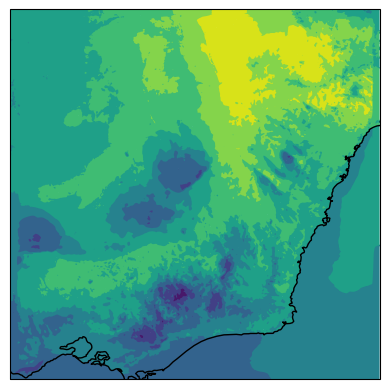

In [2]:
import iris.plot as iplt
import matplotlib.pyplot as plt

# Iris cube has metadata for dimensions that gets used when plotting
iplt.contourf(cube[0,:,:])
plt.gca().coastlines();

### Mule

Mule is a low-level library for working with UM related files, including fieldsfile, ancil files and PP files. Mule lets you directly look at the 2d slices stored in the file, it does not aggregate them into full fields.

https://code.metoffice.gov.uk/doc/um/mule/latest/

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/mule/stashmaster.py:259: UserWarning: 
Unable to load STASHmaster from version string, path does not exist
Path: /g/data/access/umdir/vn12.2/ctldata/STASHmaster/STASHmaster_A
Please check that the value of mule.stashmaster.STASHMASTER_PATH_PATTERN is correct for your site/configuration
  warnings.warn(msg)


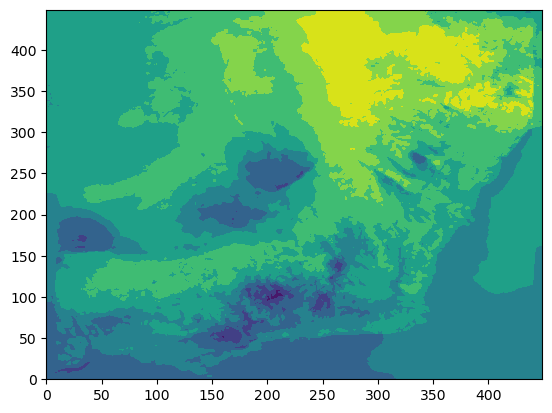

In [3]:
import os
import mule

os.environ['UMDIR'] = '/g/data/access/umdir'
mf = mule.load_umfile(os.path.expanduser('~/cylc-run/u-cy369/share/cycle/20200120T0000Z/aus2200/d0198/RA3/um/umnsaa_pvera000'))

for f in mf.fields:
    if f.lbuser4 == 3236: # Stash code for 1.5m temperature
        data = f.get_data() # 2d lat-lon slice of the data
        # See UMDP F03 for the list of field attributes
        break

# Mule just returns a numpy array, there is no metadata
plt.contourf(data);

### Xarray

If you're familiar with using Xarray with NetCDF data it's possible to convert an Iris cube to an Xarray DataArray. Both libraries can do similar things but their interfaces are quite different. You may find it simpler to work with one or the other.

https://docs.xarray.dev/en/latest/index.html

https://docs.xarray.dev/en/latest/generated/xarray.DataArray.from_iris.html

In [4]:
import xarray

da = xarray.DataArray.from_iris(cube)
da

<xarray.DataArray 'air_temperature' (time: 7, latitude: 450, longitude: 450)>
dask.array<filled, shape=(7, 450, 450), dtype=float32, chunksize=(1, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 2020-01-20T00:01:15 ... 20...
  * latitude                 (latitude) float32 -38.88 -38.87 ... -30.01 -29.99
  * longitude                (longitude) float32 143.2 143.2 ... 152.0 152.1
    forecast_reference_time  datetime64[ns] ...
    height                   float64 ...
    forecast_period          (time) timedelta64[ns] ...
Attributes:
    standard_name:  air_temperature
    units:          K
    source:         Data from Met Office Unified Model
    um_version:     12.2
    STASH:          m01s03i236

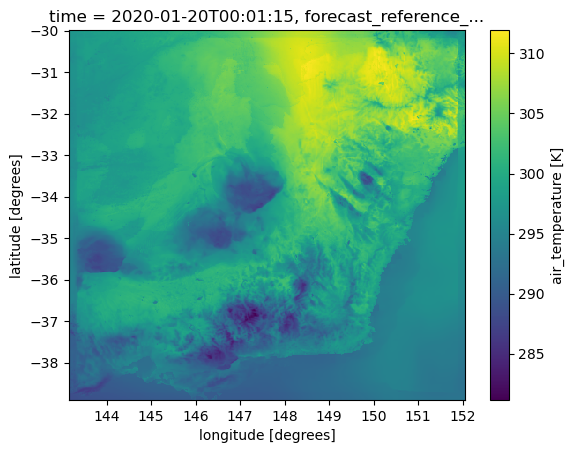

In [5]:
da[0,:,:].plot();

### Exercise

* Make a plot from the output data